# networkm

> Network Models based on networkx MultiDiGraph objects endowed with dynamics, based on `networkx`. `Graph Functions` contains various manipulation tools for networkx MultiDiGraphs. `Model Functions` contains methods of simulating these graphs as coupled, time-delayed differential equations with noise, with current support for Boolean functions / Boolean networks. `Network Class` contains the culmination of these functions in a single `BooleanNetwork` class object for pipelined analysis. Accelerated with `numba`. 

## Install

`pip install networkm`

## How to use

In [ ]:
import networkm
from networkm import *

Warming up integrator; future calls will be accelerated.
bool_integral : Elapsed time: 2.7308 seconds
bool_integral_risefall : Elapsed time: 1.9508 seconds


Check out the other pages for detailed examples; here we showcase two example `BooleanNetworks`. Any Boolean Network has dynamics of the form

    tau*dxdt=-x(t)+f(y(t-d))+noise

where tau is a time-constant, f is a logical function, y are the nodes flowing into node x after some time-delay d, and the noise term is random.

To start, we consider a simple example knwon as a Repressilator https://en.wikipedia.org/wiki/Repressilator, with real-world implications in e.g gene-regulatory networks.

The repressilator is a ring of 3 nodes which connect to their left neighbor and cyclically invert eachother.

In [ ]:
g=ring(N=3,left=True,right=False,loop=False)
print_graph(g)

|Node|Predecessors|Successors|
|0   |1           |2         |
|1   |2           |0         |
|2   |0           |1         |



We model this with the simplest case, as follows. We give each node the NOT function. This function is executed differentially with a time-constant of 1. The node receives its neighbors state instantly; we put no explicit time-delays along edges, and include no noise. We initialize one node to 1, and hold all nodes at their steady-state value from this configuration for the default value of one time-constant. Then they are released and have the following dynamics:

bool_integral : Elapsed time: 2.2616 seconds


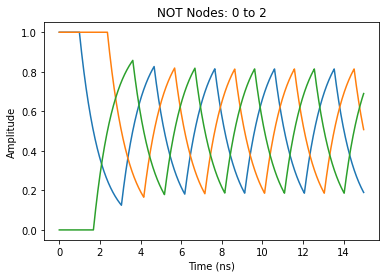

In [ ]:
m=BooleanNetwork(g=ring(N=3,left=True,right=False,loop=False),
                 f=NOT,
                 tau=1,
                 delay=0,
                 noise=0, 
                 a=np.inf, #this makes the derivative integer-valued; see `sigmoid` function
                 init=[1,0,0],
                 hold=None,
                 edge_replacements=None,
                 T=15,
                 dt=0.01,
                 plot=True
                )

In [ ]:
m

|Node|Predecessors|Successors|
|0   |1           |2         |
|1   |2           |0         |
|2   |0           |1         |

For a more complex example we consider a "Hybrid Boolean Network" composed of a multiplexer - which forces inital conditions using a clock - connected to a chaotic ring network, which executes the XOR function. This has real-world implications in e.g cryptography and physically unclonable functions (PUF) as an HBN-PUF - see https://ieeexplore.ieee.org/document/9380284.

More explicitly, we consider a 16-node ring where each node executes the 3-input XOR function on itself and its two neighbors. We include noise, time-delays, different rise/fall times for tau, and replace each node with itself + a multiplexer that sets the initial condition and copies the state thereafter, with its own set of dynamical constants.

bool_integral_risefall : Elapsed time: 0.0169 seconds


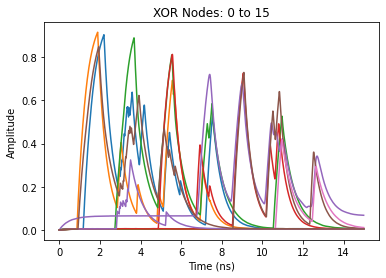

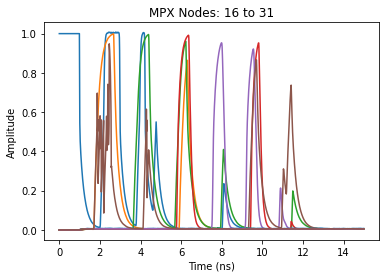

In [ ]:
m=BooleanNetwork(g = ring(N=16,right=True,left=True,loop=True),

          a = (rng.normal,15,5),
          tau = (rng.normal,[0.5,0.4],[0.1,0.05]),
          f = XOR,
          

          delay = (rng.normal,1,0.1),

          edge_replacements = dict(
              lengths = 1,
              delay = (rng.normal,0.5,0.1),
              node_attrs = dict(
                  a = (rng.normal,15,5),
                  tau = (rng.normal,[0.2,0.15],[0.05,0.05]),
                  f = MPX
              ),
              label = lambda g,node,iterable : len(g)+iterable
          ),

          T = 15,
          dt = 0.01,
          noise = 0.01,
          init = None,
          hold = None,
          
          plot=True,
          view='in'
         )

In [ ]:
m

|Node|Predecessors|Successors|
|0   |16, 17, 31  |16        |
|1   |16, 17, 18  |17        |
|2   |17, 18, 19  |18        |
|3   |18, 19, 20  |19        |
...
|28  |12          |11, 12, 13|
|29  |13          |12, 13, 14|
|30  |14          |13, 14, 15|
|31  |15          |0, 14, 15 |

In [ ]:
sidis.refresh()